In [1]:
import arpys
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import filedialog
from matplotlib import rc
import xarray as xr
import numpy as np
import sys
import os
import igor.binarywave as igor
import latex
import Mdc

# 1. Prepare the 'data' object

In [4]:
file = 'Cut_16K_k.ibw'
wave = igor.load(file)
print(f"igor wave loaded as {type(wave)}")
meta = wave['wave']['wData']
print(f"Meta data contained in {type(meta)} of size {meta.shape}")

row_start = wave['wave']['wave_header']['sfB'][0]
row_delta = wave['wave']['wave_header']['sfA'][0]
row_num = wave['wave']['wave_header']['nDim'][0]

column_start = wave['wave']['wave_header']['sfB'][1]
column_delta = wave['wave']['wave_header']['sfA'][1]
column_num = wave['wave']['wave_header']['nDim'][1]

row = np.arange(row_start, row_start+row_num*row_delta, row_delta)
column = np.arange(column_start, column_start+column_num*column_delta, column_delta)
dims = ['binding','kx']
coords = {'binding':row,'kx':column}

data_xr = xr.DataArray(wave['wave']['wData'], coords=coords, dims=dims, name="BSCCO_16K")

igor wave loaded as <class 'dict'>
Meta data contained in <class 'numpy.ndarray'> of size (801, 876)


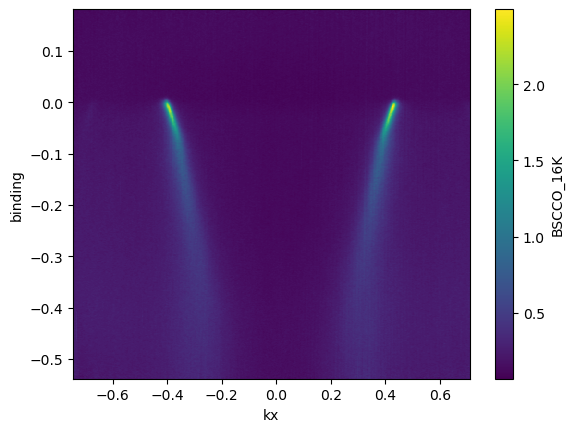

In [6]:
BSCCO_12K = data_xr.loc[-0.539:0.181, -0.745:0.711]
BSCCO_12K.plot()

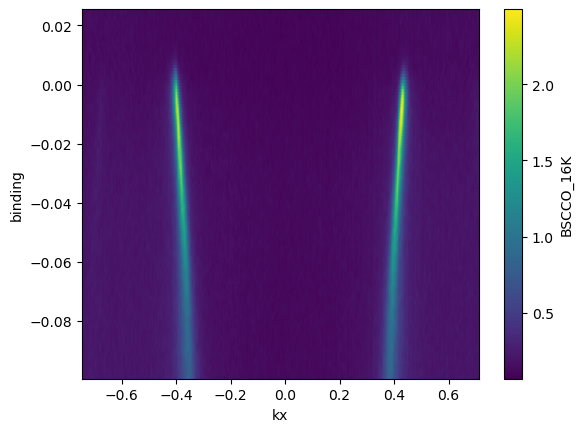

In [7]:
# Select the region to fit on
data = BSCCO_12K.sel(binding=slice(-0.1, 0.025))
data.plot()

# 2. Try some MDC fitting

## a. Single fit

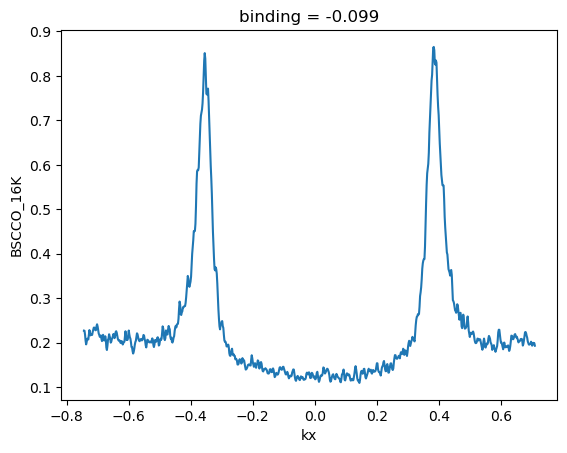

In [8]:
# Take a quick look at the first slice of MDC
E_val = -0.1
mdc = data.mdc.get_mdc(E_val)
mdc.plot()

In [9]:
# Looks like there are two peaks, let's try "two voigts + a linear backgroun"
from lmfit import Model, CompositeModel
from lmfit.models import VoigtModel, LorentzianModel, GaussianModel, LinearModel, QuadraticModel

# Build the model
voigt1 = VoigtModel(prefix='voigt1_')
voigt2 = VoigtModel(prefix='voigt2_')
linear_bkg = LinearModel(prefix='bkg_')
mod = linear_bkg + voigt1 + voigt2

In [10]:
# Initialize the parameters
params = linear_bkg.make_params()
params['bkg_intercept'].set(value=0.1)
params['bkg_slope'].set(value=0.00001)

params.update(voigt1.make_params())
params['voigt1_center'].set(value=0.4)
params['voigt1_sigma'].set(value=0.005,vary=False)
params['voigt1_amplitude'].set(value=1.5, min=0)
params['voigt1_gamma'].set(value=0.03,min=0,vary=True)

params.update(voigt2.make_params())
params['voigt2_center'].set(value=-0.4)
params['voigt2_sigma'].set(value=0.005,vary=False, expr='voigt1_sigma')
params['voigt2_amplitude'].set(value=1.4, min=0)
params['voigt2_gamma'].set(value=0.03,min=0,vary=True)

params

name,value,initial value,min,max,vary,expression
bkg_slope,1.0000e-05,1e-05,-inf,inf,True,
bkg_intercept,0.10000000,0.1,-inf,inf,True,
voigt1_amplitude,1.50000000,1.5,0.00000000,inf,True,
voigt1_center,0.40000000,0.4,-inf,inf,True,
voigt1_sigma,0.00500000,0.005,0.00000000,inf,False,
voigt1_gamma,0.03000000,0.03,0.00000000,inf,True,
voigt1_fwhm,0.06238090,None,-inf,inf,False,1.0692*voigt1_gamma+sqrt(0.8664*voigt1_gamma**2+5.545083*voigt1_sigma**2)
voigt1_height,15.5059244,None,-inf,inf,False,"(voigt1_amplitude/(max(1e-15, voigt1_sigma*sqrt(2*pi))))*real(wofz((1j*voigt1_gamma)/(max(1e-15, voigt1_sigma*sqrt(2)))))"
voigt2_amplitude,1.40000000,1.4,0.00000000,inf,True,
voigt2_center,-0.40000000,-0.4,-inf,inf,True,


In [11]:
# Apply the single fit
result = data.mdc.single_fit(model=mod, params=params, E_val=-0.1, method="least_squares") 
# result is an object the the ModelResult classs returned by lmfit

In [12]:
# Take a look at the fit results 
print(result.fit_report())

[[Model]]
    ((Model(linear, prefix='bkg_') + Model(voigt, prefix='voigt1_')) + Model(voigt, prefix='voigt2_'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 180
    # data points      = 826
    # variables        = 8
    chi-square         = 1.08122535
    reduced chi-square = 0.00132179
    Akaike info crit   = -5467.40082
    Bayesian info crit = -5429.66807
    R-squared          = 0.94246537
[[Variables]]
    bkg_slope:        -0.01895490 +/- 0.00360120 (19.00%) (init = 1e-05)
    bkg_intercept:     0.15601323 +/- 0.00164408 (1.05%) (init = 0.1)
    voigt1_amplitude:  0.06192571 +/- 0.00116682 (1.88%) (init = 1.5)
    voigt1_center:     0.38766205 +/- 4.1828e-04 (0.11%) (init = 0.4)
    voigt1_sigma:      0.005 (fixed)
    voigt1_gamma:      0.02752915 +/- 6.7675e-04 (2.46%) (init = 0.03)
    voigt1_fwhm:       0.05763402 +/- 0.00129596 (2.25%) == '1.0692*voigt1_gamma+sqrt(0.8664*voigt1_gamma**2+5.545083*voigt1_sigma**2)'
    voigt1_height:   

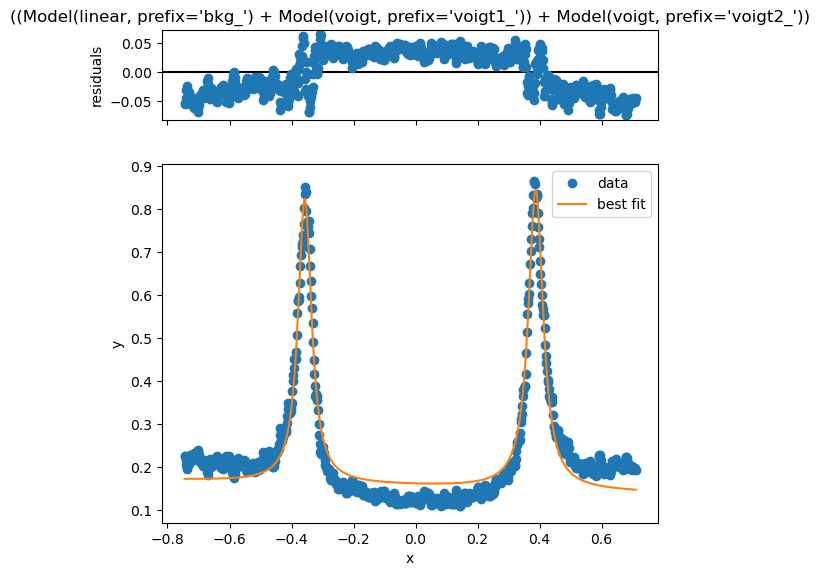

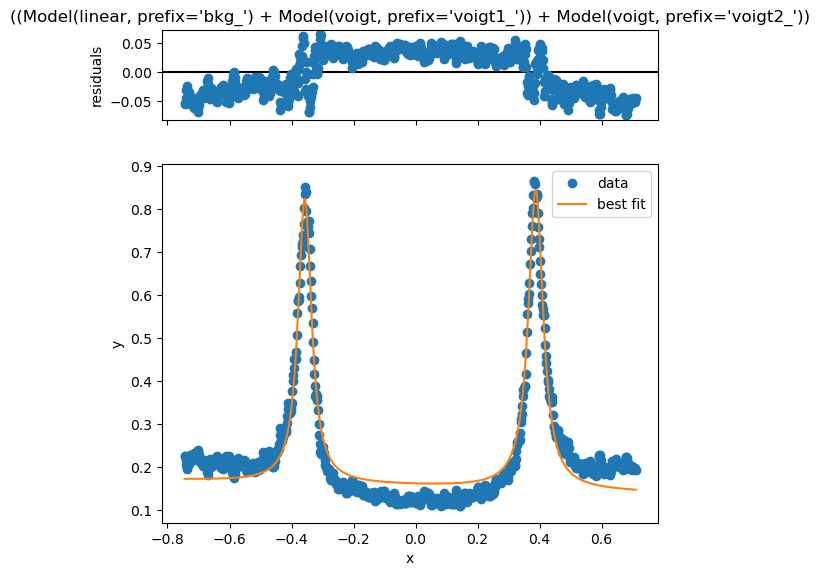

In [13]:
# Plot the fit and the residuals
result.plot()

## b. group fit for E=[-0.1, 0.01]eV

In [14]:
# Update the initial parameters with the fitting result
params = result.params

# Apply the group fit
data.mdc.group_fit(model=mod, params=params, low_E=-0.1, high_E=0.01, init_E=-0.1, method="least_squares") 
# 'init_E' can be any value between 'low_E' and 'high_E", for example, if init_E = -0.03, it will first fit from [-0.03, 0.01], then [-0.03, -0.1], and finally combine the results 

results = data.mdc.results

### plot the extracted peak positions

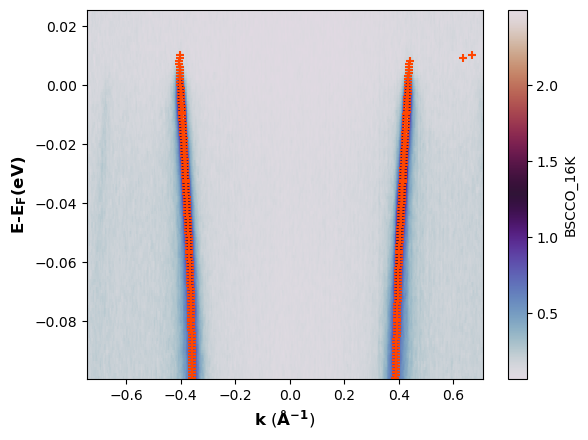

In [15]:
data.mdc.plot_dispersion(names=['voigt1_center', 'voigt2_center']) # Include names of all of the peak centers to plot

### plot the MDC stack

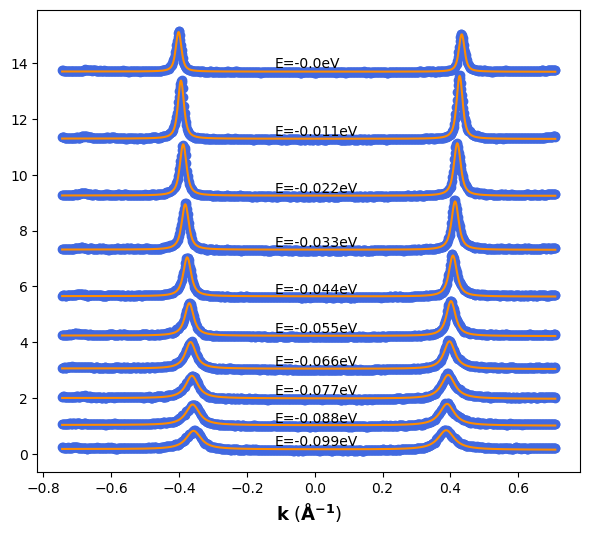

In [16]:
data.mdc.plot_waterfall(N=10, init=0, text=True) # By 'text=False' it will remove the printed energy values

## c. Deeper look at the fitting results

### check the fitted parameters

In [17]:
param_report = data.mdc.df_params()
param_report

,bkg_slope,bkg_intercept,voigt1_amplitude,voigt1_center,voigt1_sigma,voigt1_gamma,voigt1_fwhm,voigt1_height,voigt2_amplitude,voigt2_center,voigt2_sigma,voigt2_gamma,voigt2_fwhm,voigt2_height
-0.099,-0.018955,0.156013,0.061926,0.387662,0.005,0.027529,0.057634,0.694427,0.053414,-0.357246,0.005,0.024847,0.052519,0.659385
-0.098,-0.019245,0.154942,0.062219,0.388052,0.005,0.028029,0.058593,0.685954,0.054002,-0.357085,0.005,0.025514,0.053787,0.650363
-0.097,-0.016865,0.154955,0.061977,0.388269,0.005,0.027290,0.057177,0.700728,0.054531,-0.357342,0.005,0.026372,0.055421,0.636717
-0.096,-0.015783,0.155527,0.061294,0.388175,0.005,0.026149,0.054997,0.721393,0.054389,-0.357370,0.005,0.026054,0.054815,0.642318
-0.095,-0.014672,0.155265,0.060862,0.388354,0.005,0.025768,0.054270,0.726226,0.054617,-0.357800,0.005,0.025670,0.054084,0.654042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.006,-0.005637,0.119992,0.008376,0.436736,0.005,0.008094,0.022632,0.261375,0.009742,-0.404310,0.005,0.007268,0.021349,0.326536
0.007,-0.006527,0.119213,0.006435,0.438180,0.005,0.011073,0.027487,0.159727,0.007003,-0.404899,0.005,0.008377,0.023079,0.213396
0.008,-0.008583,0.118398,0.006024,0.440514,0.005,0.017801,0.039360,0.100709,0.004567,-0.405895,0.005,0.008135,0.022696,0.142016
0.009,-0.123343,0.045527,0.232583,0.633935,0.005,0.428121,0.856419,0.172903,0.003013,-0.404760,0.005,0.007784,0.022147,0.096538


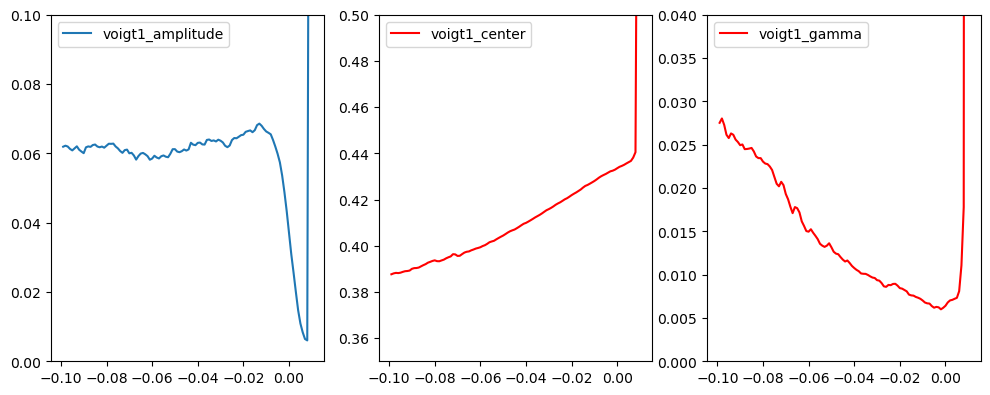

In [18]:
# To plot parameters of interest
fig, axes = plt.subplots(nrows=1,
                      ncols=3,
                      figsize=(12,4.5))
ax1, ax2, ax3 = axes
# plot the amplitude of voigt1 
ax1.plot(param_report.index, param_report["voigt1_amplitude"], label='voigt1_amplitude')
ax1.set_ylim(0, 0.1)
ax1.legend()
# plot the center location of voigt1
ax2.plot(param_report.index, param_report["voigt1_center"], label='voigt1_center', color='red')
ax2.set_ylim(0.35, 0.5)
ax2.legend()
# plot the hwhm of the lorentzian component for voigt1
ax3.plot(param_report.index, param_report["voigt1_gamma"], label='voigt1_gamma', color='red')
ax3.set_ylim(0, 0.04)
ax3.legend()

### check the fit status and statistics

In [19]:
# there is a lot more information spitted out from lmfit, all contained in the "result" object
# common attritubes of interst: result.success (whether or not the fit succeeded), result.chisqr (chi-square value), and result.redchi (the reduced-Chi2)

# Specify the attributes to look at
attr_list = ['success', 'lmdif_message', 'chisqr', 'redchi', 'errorbars']

# Generate a dataframe of the above attributes
fit_report = data.mdc.df_fitreport(attr_list=attr_list)
fit_report

,success,lmdif_message,chisqr,redchi,errorbars
-0.099,True,None,1.081225,0.001322,True
-0.098,True,None,1.038208,0.001269,True
-0.097,True,None,1.033060,0.001263,True
-0.096,True,None,1.009784,0.001234,True
-0.095,True,None,1.088958,0.001331,True
...,...,...,...,...,...
0.006,True,None,0.308757,0.000377,True
0.007,True,None,0.288123,0.000352,True
0.008,True,None,0.249318,0.000305,True
0.009,True,None,0.111332,0.000136,True


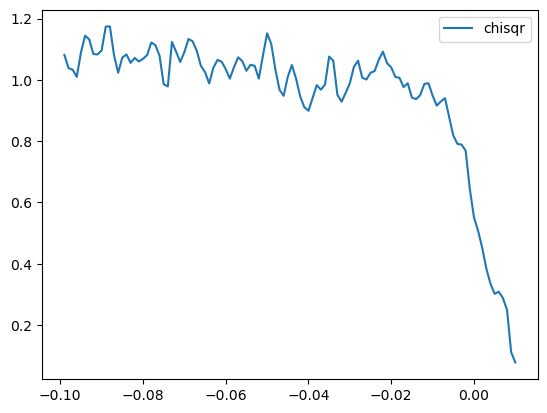

In [20]:
# To plot the chisquare as a function of the binding energy
fig, ax = plt.subplots()
ax.plot(fit_report.index, fit_report["chisqr"], label='chisqr')
ax.legend()

### plot components of a fit

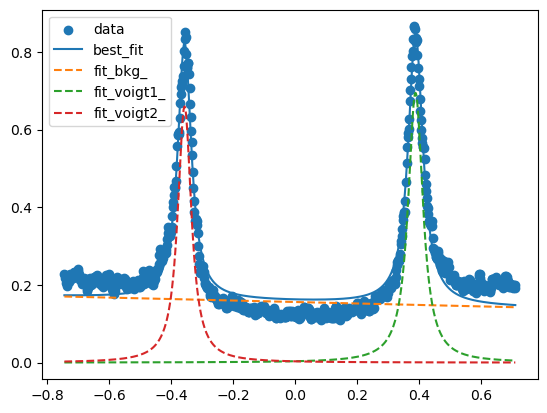

In [21]:
# To plot the decomposed fit at a certain energy
E_val = -0.1
data.mdc.plot_components(-0.1)